In [1]:
import pickle, os
import networkx as nx

In [2]:
#Load and build graph
with open('./processed_data/connectivity.pkl', 'rb') as handle:
    France = pickle.load(handle)
    
France = nx.Graph(France)

In [3]:
#Load and add attributes dict
with open('./processed_data/departments.pkl', 'rb') as handle:
    France_atts = pickle.load(handle)

In [5]:
#Load distances and times
with open('./processed_data/distances_times.pkl', 'rb') as handle:
    France_dist = pickle.load(handle)

In [6]:
#Set department name
nx.set_node_attributes(France,
            {key:value['name'] for key, value in France_atts.items()},
            'name')

In [7]:
#Set department coordinates
nx.set_node_attributes(France,
            {key:value['capital_coords'] for key, value in France_atts.items()},
            'coords')

In [8]:
#Set department capital
nx.set_node_attributes(France,
            {key:value['capital'] for key, value in France_atts.items()},
            'capital')

In [9]:
#Set department icu
nx.set_node_attributes(France,
            {key:value['beds']['icu'] for key, value in France_atts.items()},
            'icu')

In [10]:
#Set department acute
nx.set_node_attributes(France,
            {key:value['beds']['acute'] for key, value in France_atts.items()},
            'acute')

In [11]:
#Set distances and times as edge attributes
nx.set_edge_attributes(France, 
                       {(u,val['code']):val['distance'] for u,value in France_dist.items() for val in value},
                       'distance')

In [12]:
#Set distances and times as edge attributes
nx.set_edge_attributes(France, 
                       {(u,val['code']):val['time'] for u,value in France_dist.items() for val in value},
                       'time')

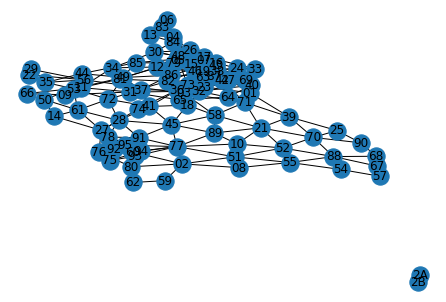

In [13]:
nx.draw(France, with_labels=True)

In [14]:
#Save pickle
nx.write_gpickle(France, path='./processed_data/France_graph.pkl')

In [15]:
#Save GML graph
nx.write_gml(France, path='./processed_data/France_graph.gml')

# Network visualizations using plotly

In [65]:
px.set_mapbox_access_token('pk.eyJ1IjoibHVjYXNtaXJhbmRhNDIiLCJhIjoiY2s5ZzB4c2dxMGJtZzNma2NsaXAzemJ3ciJ9.U9yDl5_q23VEcA1pRWgD2w')

In [258]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

def animate_graph(Graph: nx.Graph, timedata: pd.DataFrame, timeseries: str, style='carto-positron'):
    
    '''Possible values for style: 'open-street-map','white-bg', 'carto-positron',
      'carto-darkmatter', 'stamen-terrain','stamen-toner', 'stamen-watercolor',
      'basic', 'streets', 'outdoors', 'light', 'dark', 'satellite', 'satellite-streets'''
    
    df = {'dep':[], 'name':[], 'lat':[], 'lon':[], 'icu':[]}
    for node in France.nodes():
        df['dep'].append(node)
        df['name'].append(Graph.nodes[node]['name'])
        df['lat'].append(Graph.nodes[node]['coords']['lat'])
        df['lon'].append(Graph.nodes[node]['coords']['lng'])
        df['icu'].append(Graph.nodes[node]['icu'])

    df = pd.DataFrame(df)
    df = pd.merge(df, timedata)
    df['Date'] = pd.to_datetime(df.jour).astype(str)
    df.sort_values('Date', inplace=True)
    
    edge_x = []
    edge_y = []
    for edge in Graph.edges():
        y0, x0 = Graph.nodes[edge[0]]['coords'].values()
        y1, x1 = Graph.nodes[edge[1]]['coords'].values()
        edge_x.append(x0)
        edge_x.append(x1)
        edge_y.append(y0)
        edge_y.append(y1)

    fig = px.scatter_mapbox(df, lat='lat', lon='lon', center = {"lat": 46.7111, "lon": 1.7191}, 
                            color=timeseries, size=timeseries, mapbox_style=style, 
                            animation_frame='Date', color_continuous_scale='bluered', 
                            size_max=55, zoom=4.9, opacity=0.6, hover_name='name',
                            width=800, height=800)

    fig.add_scattermapbox(
        lon=edge_x, lat=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines', opacity=0.4)

    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      showlegend=False,
                      transition={'duration':1, "easing": "linear"})
    fig.show()

In [260]:
animate_graph(France, pd.read_csv('./France_Hospital_data/date_dep.csv'), 'dc')